In [21]:
%load_ext autoreload
%autoreload 2a

import importlib
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

importlib.reload(lcwgsus)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/gpfs3/well/band/users/rbx225/GAMCC


<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

# Currently working on: HLA comparison

In [134]:
def resolve_ambiguous_hla_type(r):
    if pd.isna(r['Included Alleles']):
        r['Included Alleles'] = str(-9)
        return r
    alleles = r['Included Alleles'].split('/')
    two_fields = list(set([":".join(i.split(':', 2)[:2]) for i in alleles]))
    r['Included Alleles'] = '/'.join(two_fields)
    return r
def check_letter(s):
    for c in s:
        if c.isalpha():
            return True

def check_column(s):
    if ':' in s:
        return True

def clean_hla(r, locis = locis):
    for i in locis:
        allele = r[i]
        if check_letter(allele) or not check_column(allele):
            r[i] = '-9'
        else:
            r[i] = ":".join(allele.split(':', 2)[:2])
    return r

def reorder_alleles(r):
    a1 = r['A1']
    a2 = r['A2']
    if a1 < a2:
        r['A1'] = a1
        r['A2'] = a2
    else:
        r['A2'] = a2
        r['A1'] = a1
    return r

def clean_hla_imputed(r):
    r['sample_name'] = sample_linker[r['sample_name']]
    a1 = r['bestallele1'].split('*')[1]
    a2 = r['bestallele2'].split('*')[1]
    if a1 < a2:
        r['bestallele1'] = a1
        r['bestallele2'] = a2
    else:
        r['bestallele1'] = a2
        r['bestallele2'] = a1
    return r

def compare_hla_types(r):
    typed = set(r[['A1', 'A2']])
    imputed = set(r[['bestallele1', 'bestallele2']])
    if typed == imputed:
        r['match'] = 2
    else:
        r['match'] = len(typed.intersection(imputed))
    return r

In [23]:
loci = ['A', 'B', 'C', 'DQB1', 'DRB1']

hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
hla = hla[['SampleID', 'Locus', 'Included Alleles']]
hla = hla[hla['Locus'].isin(loci)].reset_index(drop = True)

hla = hla.apply(resolve_ambiguous_hla_type, axis = 1)

sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
sample_linker = sample_linker[~sample_linker['Sample_Name'].str.contains('mini')]
fv = list(sample_linker['Chip_Name'].values)
hla = hla[hla['SampleID'].isin(fv)]

for s in hla['SampleID'].unique():
    tmps = hla[hla['SampleID'] == s]
    for l in loci:
        tmpl = tmps[tmps['Locus'] == l]
        repeat = 2 - tmpl.shape[0]
        if repeat == 2:
            hla.loc[len(hla)] = [s, l, '-9']
            hla.loc[len(hla)] = [s, l, '-9']
        if repeat == 1:
            hla.loc[len(hla)] = [s, l, tmpl.iloc[0,2]]
hla = hla.sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
hla

,SampleID,Locus,Included Alleles
0,GAM013489,A,02:01
1,GAM013489,B,44:03
2,GAM013489,B,82:01
3,GAM013489,C,03:02
4,GAM013489,C,03:03
...,...,...,...
1956,GAM975418,C,15:05
1957,GAM975418,DQB1,04:87/04:02
1958,GAM975418,DQB1,05:237/05:263/05:01
1959,GAM975418,DRB1,03:02


In [24]:
sample_missing = pd.DataFrame(columns = ['sample', 'missing', 'ambiguous'])
for s in hla['SampleID'].unique():
    tmps = hla[hla['SampleID'] == s]
    missing = tmps[tmps['Included Alleles'] == '-9'].shape[0]
    ambiguous = tmps[tmps['Included Alleles'].str.contains('/')].shape[0]
    sample_missing.loc[len(sample_missing)] = [s, missing, ambiguous]

In [25]:
sample_missing

,sample,missing,ambiguous
0,GAM013489,0,3
1,GAM013627,0,1
2,GAM013795,1,1
3,GAM015283,0,1
4,GAM018372,1,1
...,...,...,...
205,GAM951638,0,2
206,GAM962501,0,2
207,GAM967203,0,2
208,GAM974016,1,1


In [26]:
type_missing = pd.DataFrame(columns = ['type', 'missing', 'ambiguous'])
for l in hla['Locus'].unique():
    tmpl = hla[hla['Locus'] == l]
    missing = tmpl[tmpl['Included Alleles'] == '-9'].shape[0]
    ambiguous = tmpl[tmpl['Included Alleles'].str.contains('/')].shape[0]
    type_missing.loc[len(type_missing)] = [l, missing, ambiguous]

In [27]:
type_missing

,type,missing,ambiguous
0,A,1,0
1,B,14,0
2,C,4,0
3,DQB1,9,221
4,DRB1,73,66


In [28]:
locis = [i+'1' for i in loci] + [i+'2' for i in loci]

---

In [135]:
hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing.csv',
                  usecols = ['SampleID'] + locis)
hla = hla.apply(clean_hla, axis = 1)

triplet = hla[['SampleID', 'A1', 'A2']].apply(reorder_alleles, axis = 1)
triplet

,SampleID,A1,A2
0,GAM013489,02:01,02:01
1,GAM013627,01:02,01:02
2,GAM013795,29:02,34:02
3,GAM015283,66:01,74:01
4,GAM018372,02:01,68:02
...,...,...,...
245,GAM756481,30:02,68:01
246,GAM795384,33:01,33:01
247,GAM805329,30:01,68:02
248,GAM942670,23:01,68:01


In [140]:
sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
idt_to_exclude = list(sample_linker[sample_linker['Sample_Name'].str.contains('mini')]['Seq_Name'].values)
sample_linker = {k:v for k, v in zip(sample_linker['Seq_Name'], sample_linker['Chip_Name'])}

imputed_A = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/genes/A/quilt.hla.output.combined.topresult.txt', sep = '\t')
imputed_A = imputed_A[['sample_name', 'bestallele1', 'bestallele2', 'post_prob']]

# imputed_A = imputed_A[~imputed_A['sample_name'].isin(idt_to_exclude)]

imputed_A = imputed_A.apply(clean_hla_imputed, axis = 1).sort_values(by = 'sample_name').reset_index(drop = True)
imputed_A

,sample_name,bestallele1,bestallele2,post_prob
0,GAM013489,02:01,02:01,0.978304
1,GAM013627,01:02,01:02,0.776611
2,GAM013795,29:02,34:02,0.999989
3,GAM015283,66:01,74:01,0.998741
4,GAM018372,02:01,68:02,0.801751
...,...,...,...,...
236,GAM962501,23:01,23:01,0.999801
237,GAM967203,03:01,26:01,0.973891
238,GAM974016,23:01,33:03,0.463453
239,GAM975418,29:02,68:02,0.398663


In [141]:
merged = pd.merge(triplet, imputed_A, left_on = 'SampleID', right_on = 'sample_name', how = 'inner').drop(columns = 'sample_name')

merged['match'] = 0
merged = merged.apply(compare_hla_types, axis = 1)
merged

,SampleID,A1,A2,bestallele1,bestallele2,post_prob,match
0,GAM013489,02:01,02:01,02:01,02:01,0.978304,2
1,GAM013627,01:02,01:02,01:02,01:02,0.776611,2
2,GAM013795,29:02,34:02,29:02,34:02,0.999989,2
3,GAM015283,66:01,74:01,66:01,74:01,0.998741,2
4,GAM018372,02:01,68:02,02:01,68:02,0.801751,2
...,...,...,...,...,...,...,...
235,GAM756481,30:02,68:01,30:10,68:01,0.794835,1
236,GAM795384,33:01,33:01,31:01,None,0.282716,0
237,GAM805329,30:01,68:02,30:01,68:02,0.902348,2
238,GAM942670,23:01,68:01,23:01,68:01,0.707046,2


In [142]:
merged['match'].sum()/(merged.shape[0]*2)

0.78125

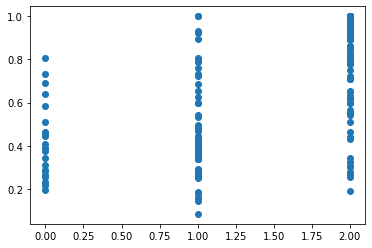

In [143]:
plt.scatter(merged['match'], merged['post_prob'])

---

In [15]:
sample_linker='data/metadata/sample_linker.csv'
sample_linker = pd.read_csv(sample_linker)
sample_linker = sample_linker[(sample_linker['Sample_Name'].str.contains('mini')) & (sample_linker['Sample_Name'].str.contains('GM'))]
sample_linker = sample_linker[sample_linker['Chip_Name'].isin(chip)]
sample_linker

,Sample_Name,Seq_Name,Chip_Name
210,GM101_mini,IDT0607,GAM314862
211,GM1114_mini,IDT0634,GAM916387
212,GM1126_mini,IDT0597,GAM684932
213,GM1135_mini,IDT0596,GAM519367
214,GM1151_mini,IDT0609,GAM870643
215,GM1211_mini,IDT0669,GAM865304
216,GM1232_mini,IDT0646,GAM806425
217,GM1293_mini,IDT0619,GAM752031
218,GM1555_mini,IDT0621,GAM892761
219,GM197_mini,IDT0631,GAM503647


In [5]:
chip = 'data/sample_tsvs/chip_gam_names.tsv'
chip = pd.read_csv(chip, header = None, names = ['Code'])['Code'].values
sl = {k:v for k, v in zip(sample_linker['Chip_Name'], sample_linker['Seq_Name'])}

idts = []

for i in chip:
    idts.append(sl[i])

res = pd.DataFrame({'seq': idts, 'chip': chip})
res.to_csv('/well/band/users/rbx225/GAMCC/data/rename_tsvs/idt_to_gam_chip.tsv', sep = ' ', index = False, header = False)

In [28]:
quilt1_vcf = '/well/band/users/rbx225/GAMCC/results/imputation/vcfs/oneKG/quilt.chr11.vcf.gz'
quilt2_vcf = '/well/band/users/rbx225/GAMCC/results/two-stage-imputation/oneKG_oneKG/vcf/chr11.dose.vcf.gz'
chip_vcf = '/well/band/users/rbx225/GAMCC/results/chip/vcf/chip_by_chr/chip.chr11.vcf.gz'
hc_vcf = '/well/band/users/rbx225/GAMCC/results/call/recal_vcf/oneKG/snps/oneKG.snps.chr11.vcf.gz'
af_txt = "data/gnomAD_MAFs/afr/gnomAD_MAF_afr_chr11.txt"

vcf_cols = [
    'chr', 'pos', 'ID', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT'
]

c = 11
pos = 5227002
vcf_lst = [chip_vcf, quilt1_vcf, quilt2_vcf]
source_lst = ['chip', 'lc', 'lc']
labels_lst = ['chip', 'lc', 'two-stage']

In [ ]:
chromosomes = [str(i) for i in range(1,23)]
h_lst = ["results/imputation_metrics/lc_chip/by_variant/lc.chip.typed.chr" + i + ".h.impacc.tsv" for i in chromosomes]
v_lst = ["results/imputation_metrics/lc_chip/by_sample/lc.chip.typed.chr" + i + ".v.impacc.tsv" for i in chromosomes]

h_dfs = [pd.read_csv(i, sep = '\t') for i in h_lst]
v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]

h = lcwgsus.average_impacc_by_chr(h_dfs)
v = lcwgsus.average_impacc_by_chr(v_dfs)

In [ ]:
dfs = [h[['AF', 'r2', 'r2_AC']], h[['AF', 'NRC', 'NRC_AC']]]
lcwgsus.plot_imputation_accuracy(dfs, title = 'r2 and NRC by variant')

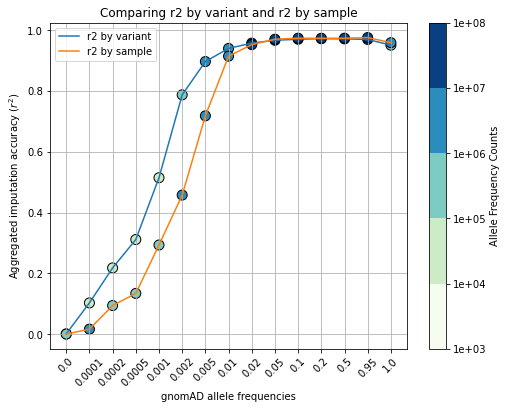

In [194]:
dfs = [h[['AF', 'r2', 'r2_AC']], v[['AF', 'r2', 'r2_AC']]]
plot_imputation_accuracy(dfs, labels = ['r2 by variant', 'r2 by sample'], title = 'Comparing r2 by variant and r2 by sample')

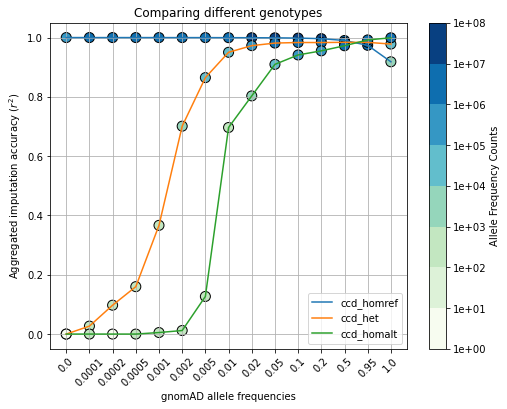

In [196]:
dfs = [h[['AF', 'ccd_homref', 'ccd_homref_AC']], h[['AF', 'ccd_het', 'ccd_het_AC']], h[['AF', 'ccd_homalt', 'ccd_homalt_AC']]]
plot_imputation_accuracy(dfs, title = 'Comparing different genotypes')